# Introducción a Pytorch usando fast.ai: 
# Clasificador de imágenes usando Google Images

*por Alonso Astroza. Inspirado en el curso [Practical Deep Learning for Coders](https://course.fast.ai/)*

Vamos a crear nuestro conjunto de datos usando Google Images. **Nota**: Vamos a repetir pasos para cada categoría que vamos a Googlear.

In [1]:
from fastai.vision import *

## Conseguir una lista de URLs

### Buscar y scrollear

Debemos ir a [Google Images](http://images.google.com) y buscar el concepto del que estemos interesados en obtener imagenes. Mientras mas específico seamos serán mejores los resultados que obtendremos.

Hay que scrollear hasta que veamos todas las imágenes que queremos bajar o hasta que se vea el botón que dice: 'Show more results'. Todas las imágenes por las que scrolleamos ahora están disponibles para que las bajemos. El número máximo de imágenes que puede mostrar Google Images es 700.

Es una buena idea poner cosas que queremos excluir de la búsqueda, por ejemplo si estás buscando un lobo de raza específica "canis lupus lupus", puede ser una buena idea excluir otras variantes de lobos:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis


### Bajar las imagenes a un archivo

Debemos correr un código Javascript en el navegador que guardará las URLs de todas las imágenes de nuestro dataset.

En Google Chrome hay que apretar <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> en Windows/Linux y <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> en macOS, y aparecerá la ventana de 'Console' javascript. En Firefox presionando <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> en Windows/Linux o <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> en macOS. Ahí es donde pegamos los comandos  JavaScript.

Antes de correr los comandos probablemente debamos deshabilitar cualquier extensión de ad blocking (uBlock, AdBlockPlus etc.) en Chrome. Si no, el comando window.open() no funciona. Luego se debe correr lo siguiente:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Crear una carperta y subir los archivos con urls al servidor

Debemos escoger un nombre adecuado que sea la etiqueta de cada conjunto de imagenes. Se pueden correr estos comandos varias veces para construir múltiples etiquetas.

In [2]:
path = Path('data')

---

In [3]:
folder = 'motos'
file = 'motos.csv'

In [4]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

_descarga las imágenes al directorio creado_

In [5]:
download_images(path/file, dest, max_pics=400)

---

In [6]:
folder = 'bicis'
file = 'bicis.csv'

In [7]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

_descarga las imágenes al directorio creado_

In [8]:
download_images(path/file, dest, max_pics=400)

---

In [9]:
folder = 'autos'
file = 'autos.csv'

In [10]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

_descarga las imágenes al directorio creado_

In [11]:
download_images(path/file, dest, max_pics=400)

---

In [12]:
path.ls()

[WindowsPath('data/autos'),
 WindowsPath('data/autos.csv'),
 WindowsPath('data/bicis'),
 WindowsPath('data/bicis.csv'),
 WindowsPath('data/export.pkl'),
 WindowsPath('data/models'),
 WindowsPath('data/motos'),
 WindowsPath('data/motos.csv')]

Finalmente tenemos que subir nuestros .csv con las urls si es que no lo hemos guardado en la misma data carpeta. Para eso hay que apretar el botón `Upload` en el directorio de trabajo y seleccionar el archivo, luego hacer click en `Upload`' por cada uno de los archivos que se desplieguen. O simplemente copiarlos en el directorio `data` en el navegador de archivos de su sistema operativo.


## Bajar las imágenes

Ahora necesitaremos bajar las imagenes desde sus respectivas urls.

fast.ai tiene una función que permite hacer exactamente eso. Solo debemos especificarle el archivo con las urls así como una carpeta de destino, con eso la función va a bajar todas las imágenes que pueda abrir. Si tiene algún problema tratando de abrir algún archivo, simplemente se lo salta y no lo baja.

¡Así que bajemos las imágenes! Notemos que podemos elegir el número máximo de imágenes a bajar. En este caso no vamos a bajar todas las urls para que los conjuntos de datos sean más acotados.

Necesitamos correr la línea de la bajada de imágenes una vez por cada categoría.

In [13]:
folder = 'motos'
file = 'motos.csv'
path = Path('data')
dest = path/folder

In [14]:
download_images(path/file, dest, max_pics=1200)

In [15]:
folder = 'bicis'
file = 'bicis.csv'
path = Path('data')
dest = path/folder

In [16]:
download_images(path/file, dest, max_pics=1200)

In [17]:
folder = 'autos'
file = 'autos.csv'
path = Path('data')
dest = path/folder

In [18]:
download_images(path/file, dest, max_pics=1200)

Luego podemos remover las imágenes que no puedan abrirse como imágen propiamente tal:

In [19]:
classes = ['motos','bicis','autos']

In [20]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

motos


bicis


autos


## Ver los datos

In [21]:
path = Path('data')


In [22]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Aprovechemos de mirar las imagenes que bajamos

In [23]:
data.classes

['autos', 'bicis', 'motos']

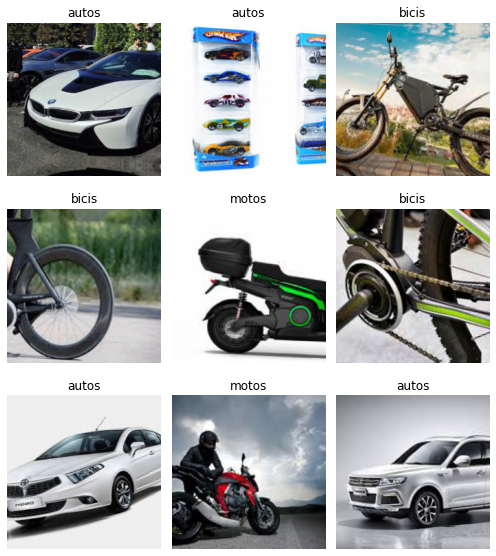

In [24]:
data.show_batch(rows=3, figsize=(7,8))

In [25]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['autos', 'bicis', 'motos'], 3, 773, 193)

---

## Entrenar el modelo

Para entrenar el modelo usaremos una [red neuronal convolucional](https://cs231n.github.io/convolutional-networks/) (resnet34). Por el momento lo necesario de saber es que estaremos construyendo un modelo que toma imágenes de entrada y como salida predice la probabilidad de que pertenezca a cada categoría.

Entrenaremos por 4 épocas (4 ciclos por todos los datos).

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.933403,0.184982,0.046632,08:56
1,0.578007,0.164277,0.046632,07:45
2,0.419333,0.186030,0.046632,07:35


In [ ]:
learn.save('stage-1')

## Resultados

Veamos los resultados que obtuvimos.

Primero miraremos si lo que predijo el modelo es razonable o no. Si no obtiene resultados que son descabellados es un buen indicador que el clasificador esta funcionando bien.

Además graficaremos la matriz de confusión.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix()

## Poniendo el modelo en producción

Primero hay que exportar el contenido del objeto `Learner` para usarlo en producción:

In [ ]:
learn.export()

Esto va a crear un archivo llamado 'export.pkl' en el directorio de trabajo que contiene todo lo necesario para publicar nuestro modelo (el modelo, los pesos de la red y alguna metadata como las clases o las transformaciones/normalizaciones realizadas).

Para predecir basta con usar la CPU, excepto a escala masiva (o entrenamiento en línea). Si la máquina donde publicaremos el modelo no tiene GPU, el cambio a CPU se realizará de manera automática. Tambien podemos probar el modelo en CPU de esta forma:

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
path=Path('test')

In [ ]:
img = open_image(path/'rocket.JPG')
img

En el entorno de producción creamos el objeto `Learner` de esta manera, solo hay que asegurarse que el directorio `path` contenga el archivo 'export.pkl' que creamos recién.

In [ ]:
path = Path('data')

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
str(pred_class)

In [ ]:
outputs